In [1]:
from randomboostingclassifier import BaseGradientBoostingClassifier 
from randomboostingclassifier import RandomBoostingClassifier

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble._forest import ForestClassifier 
from sklearn.utils.validation import check_is_fitted, check_X_y, check_array, column_or_1d

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.tree import DecisionTreeClassifier, plot_tree  

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_random_state

import warnings
from sklearn.exceptions import DataConversionWarning

# Установка фильтра до импорта scikit-learn
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Подготовка Данных

In [13]:
df = pd.read_csv('UCI_Credit_Card.csv') 
X = df.drop(['default.payment.next.month'], axis = 1)
y = df['default.payment.next.month'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

def f1(x1, x2, x3): 
    a = x1 
    b = (x2+x3)/2  
    if a == b and a == 0: 
        return 0 
    else:
        return (a - b)/max(abs(a), abs(b)) 

def f2(x1, x2, x3): 
    a = x1 
    b = (x2+x3)/2 
     
    return a - b  
df['new_feature_1'] = df.apply(lambda x: f1(x['BILL_AMT1'], x['BILL_AMT2'],  x['BILL_AMT3'] ), axis = 1) 
df['new_feature_2'] = df.apply(lambda x: f2(x['BILL_AMT1'], x['BILL_AMT2'],  x['BILL_AMT3'] ), axis = 1)   
df['new_feature_1_2_equal_zero'] = df.apply(lambda x: int( x['BILL_AMT1'] == (x['BILL_AMT2'] + x['BILL_AMT3'] )/2 and  x['BILL_AMT1'] == 0 ), axis = 1) 
df_class_1 = df[df['default.payment.next.month'] == 1].sample(5051, random_state=42)
df_class_0 = df[df['default.payment.next.month'] == 0].sample(5051, random_state=42)
df_ = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True).dropna() 
df_ = shuffle(df_, random_state=42).drop(["ID"], axis = 1)



# GridSearchCV

In [14]:
param_grid = {
    'n_estimators': [10],
    'gb_n_estimators': [1, 2,3,5,10,15,20],
    'learning_rate': [0.1],
    'max_depth': [4],
    'max_features': ['sqrt'],
}


model = RandomBoostingClassifier(
    random_state=42,
    n_jobs=-1
)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Точность на тестовой выборке:", accuracy_score(y_test, y_pred))
print("Средние значимости признаков:", best_model.feature_importances_)
print("Дисперсии значимости признаков:", best_model.feature_importances_var_)


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Лучшие параметры: {'gb_n_estimators': 20, 'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
Точность на тестовой выборке: 0.8152
Средние значимости признаков: [0.00745868 0.02921798 0.00077796 0.00282757 0.00159798 0.00776167
 0.34497039 0.14669724 0.11850676 0.06887612 0.0563474  0.04743658
 0.01602745 0.01167511 0.00764807 0.00628659 0.00768795 0.00717648
 0.03848559 0.02288396 0.01902728 0.01371031 0.00580582 0.01110903]
Дисперсии значимости признаков: [1.09768045e-05 8.34287320e-05 1.40570892e-06 2.35511105e-06
 2.07445341e-06 4.52622014e-06 2.14624432e-03 1.56429787e-03
 1.10943486e-03 6.16827296e-04 1.24281180e-03 3.13794945e-04
 1.65859724e-05 4.38604928e-05 8.33585539e-06 3.59141421e-06
 1.41696946e-05 2.38851310e-06 1.42973829e-04 7.26347270e-05
 3.31052875e-05 2.75480162e-05 2.85426907e-06 1.30830637e-05]


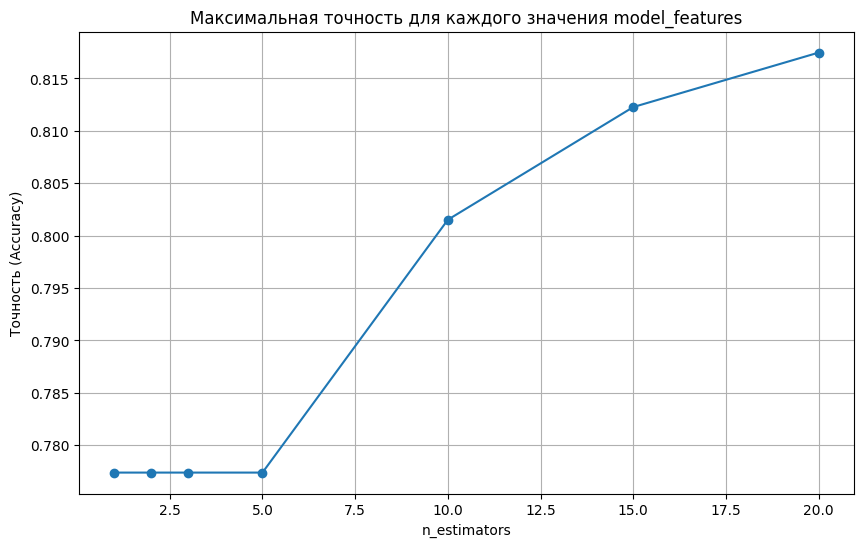

In [15]:
cv_results = grid_search.cv_results_

# Преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(cv_results)

# Группировка по max_features и нахождение максимального значения accuracy
max_accuracy_per_max_features = results_df.groupby('param_gb_n_estimators')['mean_test_score'].max()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_accuracy_per_max_features.index, max_accuracy_per_max_features.values, marker='o')
plt.title('Максимальная точность для каждого значения model_features')
plt.xlabel('n_estimators')
plt.ylabel('Точность (Accuracy)')
plt.grid(True)
plt.show()

# Вырождение модели в случай одного дерева и сравнение с DecisionTreeClassifier

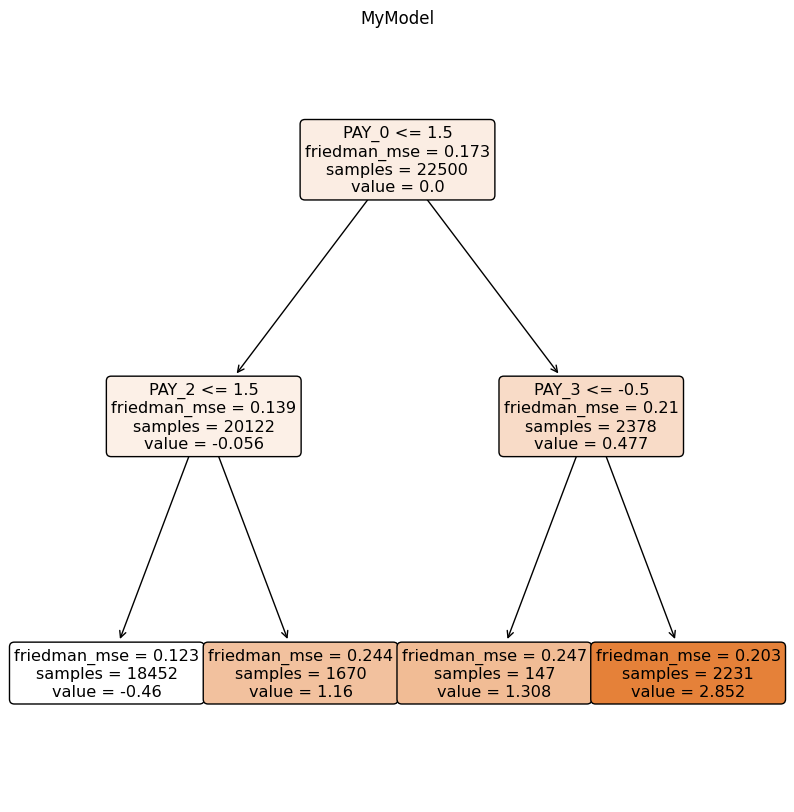

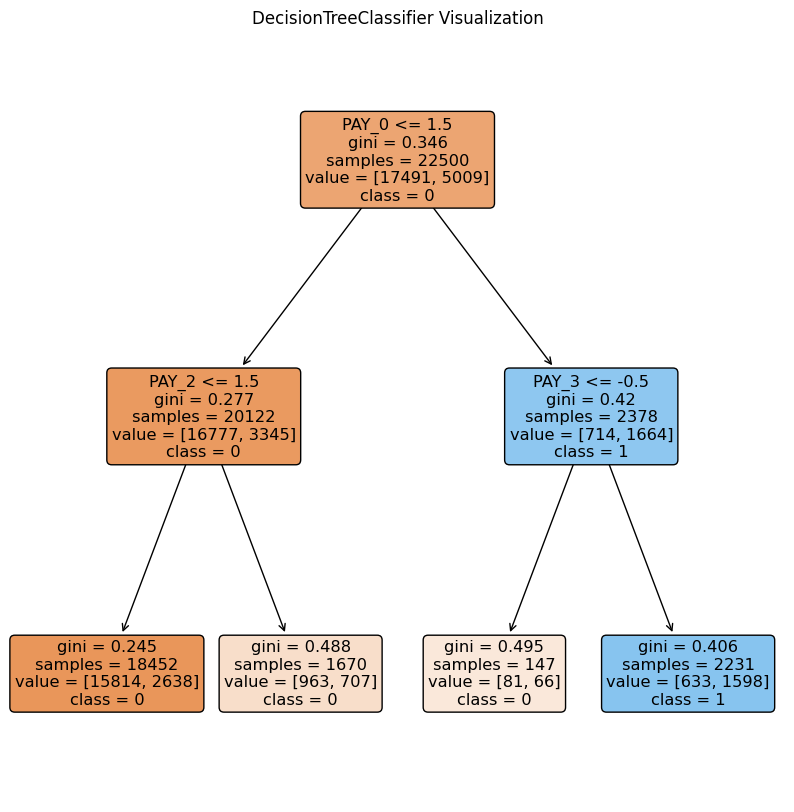

In [16]:
plt.figure(figsize=(10,10))
rbc = RandomBoostingClassifier( n_estimators  = 1 , gb_n_estimators = 1, learning_rate = 0.1, max_depth =  2, max_features =  1., bootstrap = False)  

rbc.fit(X_train, y_train)
selected_tree = rbc.estimators_[0].estimators_[0, 0] 
plot_tree(selected_tree, filled=True,feature_names=X_train.columns,  class_names=np.unique(y_train).astype(str), rounded=True) 
plt.title("MyModel")
plt.show()   




plt.figure(figsize=(10,10))
tree_clf = DecisionTreeClassifier(max_depth=2, max_features = 18, random_state=69) 
tree_clf.fit(X_train, y_train)
#tree_clf.fit(X_train_higgs.sample(frac=1, replace=True, random_state = 60), y_train_higgs.sample(frac=1, replace=True, random_state = 60))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names= np.unique(y_train).astype(str), rounded=True) 
plt.title("DecisionTreeClassifier Visualization")
plt.show()   

# Сравнение с RandomForestClassifier

In [17]:
rf_model = RandomForestClassifier(n_estimators = 30, max_depth = 3, max_features = 24, bootstrap=False,  random_state=69)
rf_model.fit(X_train, y_train)
print('rf_accuracy: ', accuracy_score(y_test, rf_model.predict(X_test)) ) 

rb = RandomBoostingClassifier( n_estimators = 30 , gb_n_estimators = 1, learning_rate=1., max_depth =  3, 
                              max_features =  24, bootstrap = False, n_jobs = 30, random_state=69) 
rb.fit(X_train, y_train)
print('accuracy rb: ', accuracy_score( y_test, rb.predict(X_test)) )

rf_accuracy:  0.8205333333333333
accuracy rb:  0.8205333333333333


# Сравнение с GradientBoostingClassifier

In [19]:
gb_model = GradientBoostingClassifier(n_estimators = 30, max_depth = 3, max_features = 1.,learning_rate=1.,  random_state=69)
gb_model.fit(X_train, y_train)
print('gb_accuracy: ', accuracy_score(y_test, gb_model.predict(X_test)) ) 

rb = RandomBoostingClassifier( n_estimators = 1 , gb_n_estimators = 30, learning_rate=1., max_depth =  3, 
                              max_features =  1., bootstrap = False, n_jobs = 30, random_state=69) 
rb.fit(X_train, y_train)
print('accuracy rb: ', accuracy_score( y_test, rb.predict(X_test)) )

gb_accuracy:  0.8114666666666667
accuracy rb:  0.8114666666666667


# Give me some credits feature importance

Accuracy of DecisionTree with max_depth=1: 0.5886
Accuracy of DecisionTree with max_depth=2: 0.5886


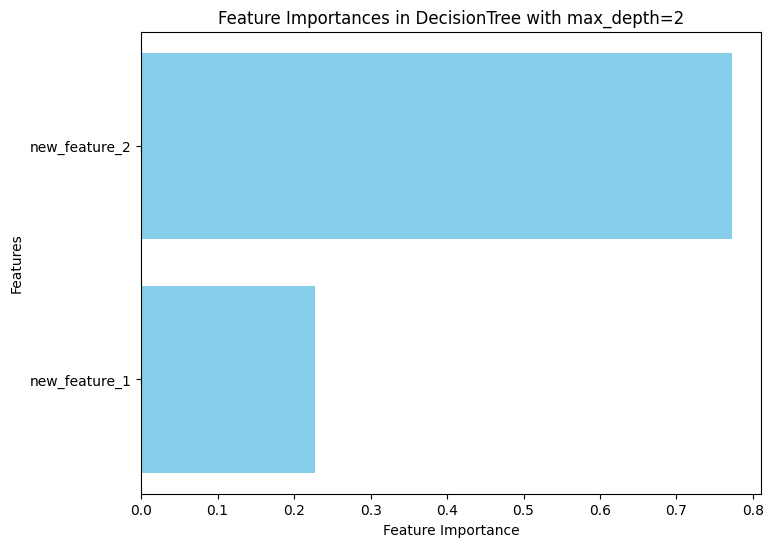

In [20]:
X = df_[['new_feature_1', 'new_feature_2']]
y = df_['default.payment.next.month']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_depth_1 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_depth_1.fit(X_train, y_train)
y_pred_1 = tree_depth_1.predict(X_test)


accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Accuracy of DecisionTree with max_depth=1: {accuracy_1:.4f}")


tree_depth_2 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_depth_2.fit(X_train, y_train)
y_pred_2 = tree_depth_2.predict(X_test)


accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Accuracy of DecisionTree with max_depth=2: {accuracy_2:.4f}")


importances = tree_depth_2.feature_importances_

plt.figure(figsize=(8, 6))
plt.barh(['new_feature_1', 'new_feature_2'], importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in DecisionTree with max_depth=2')
plt.show()

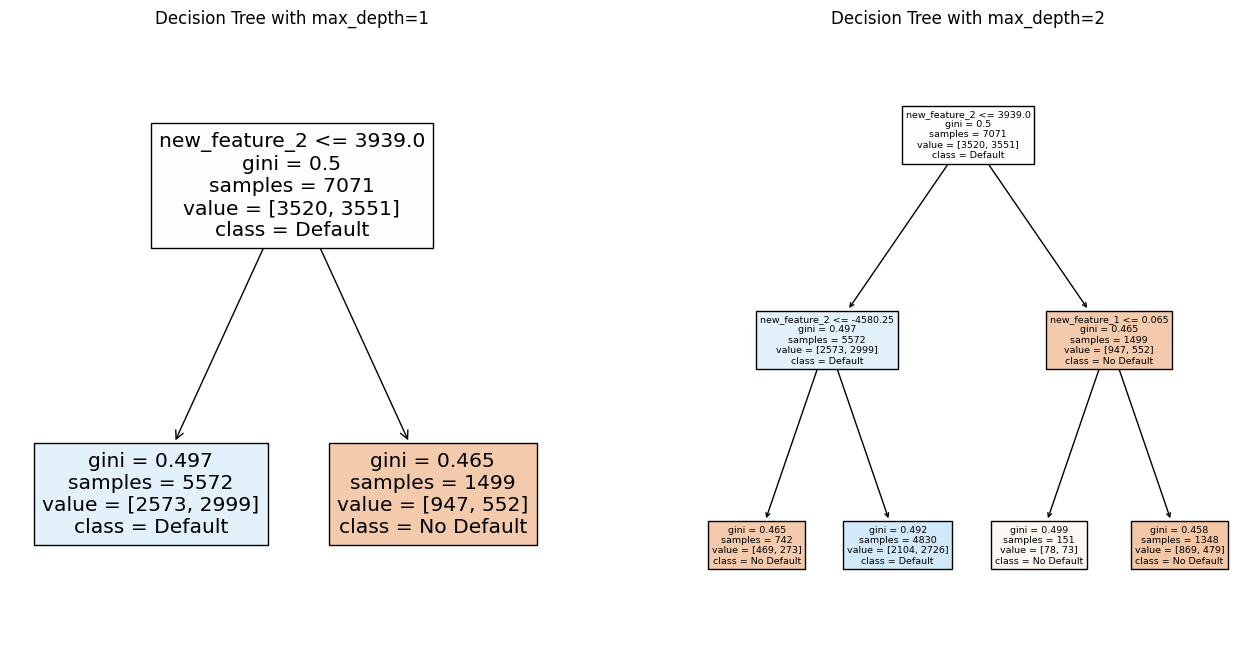

In [21]:
X = df_[['new_feature_1', 'new_feature_2', 'new_feature_1_2_equal_zero']]
y = df_['default.payment.next.month']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_depth_1 = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_depth_1.fit(X_train, y_train)


tree_depth_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_depth_2.fit(X_train, y_train)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plot_tree(tree_depth_1, filled=True, feature_names=['new_feature_1', 'new_feature_2'], class_names=['No Default', 'Default'])
plt.title("Decision Tree with max_depth=1")

plt.subplot(1, 2, 2)
plot_tree(tree_depth_2, filled=True, feature_names=['new_feature_1', 'new_feature_2'], class_names=['No Default', 'Default'])
plt.title("Decision Tree with max_depth=2")

plt.show()

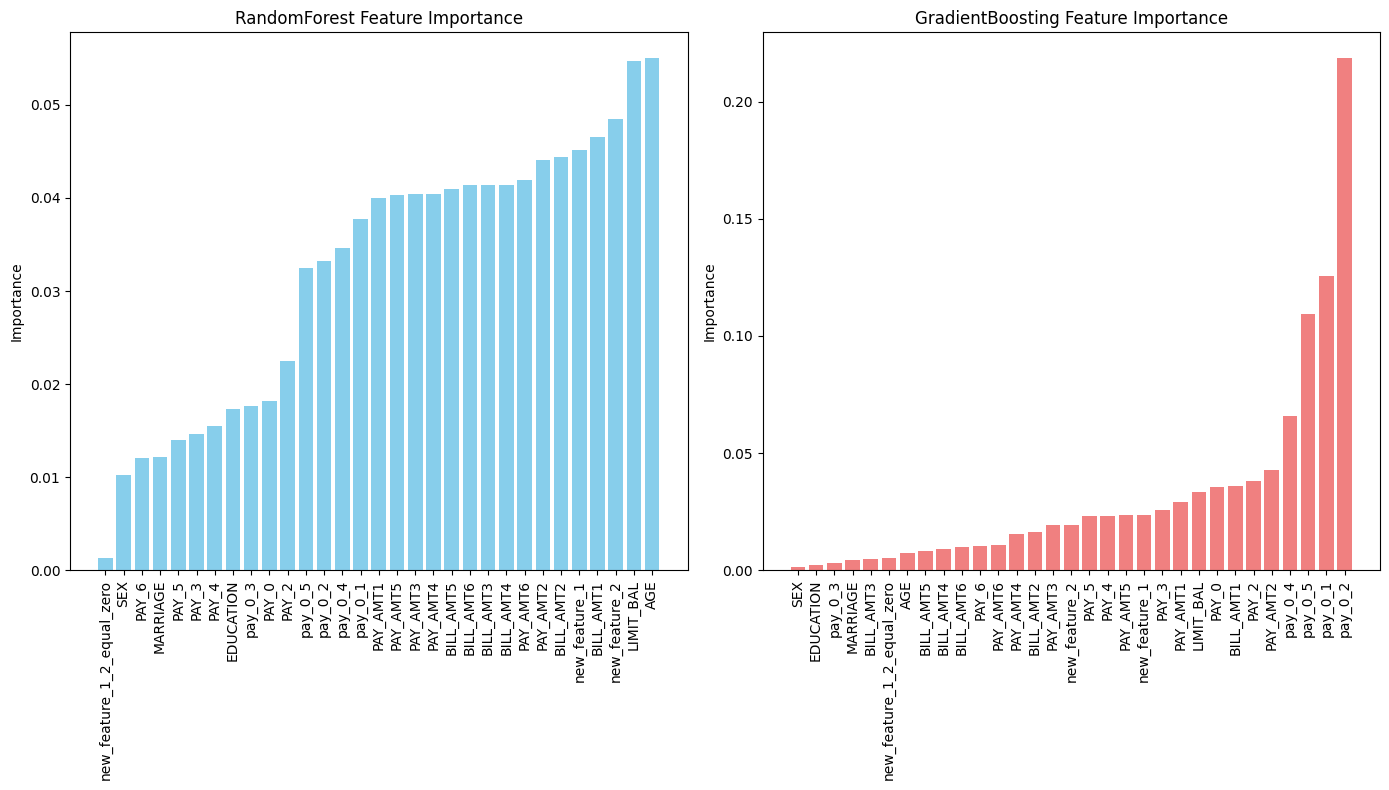

In [22]:
X = df_.drop(columns=['default.payment.next.month'])
y = df_['default.payment.next.month']

X['pay_0_1'] = X.apply(lambda x: x['PAY_0']*3, axis = 1)  
X['pay_0_2'] = X.apply(lambda x: x['PAY_0']/3+50, axis = 1)  
X['pay_0_3'] = X.apply(lambda x: x['PAY_0']*10-100, axis = 1) 
X['pay_0_4'] = X.apply(lambda x: x['pay_0_2'] + x['pay_0_3'], axis = 1) 
X['pay_0_5'] = X.apply(lambda x: x['pay_0_4']**2, axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest Importance': rf_importances,
    'GradientBoosting Importance': gb_importances
})

importance_df_rf_sorted = importance_df.sort_values(by='RandomForest Importance', ascending=True)
importance_df_gb_sorted = importance_df.sort_values(by='GradientBoosting Importance', ascending=True)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.bar(importance_df_rf_sorted['Feature'], importance_df_rf_sorted['RandomForest Importance'], color='skyblue')
plt.ylabel('Importance')
plt.title('RandomForest Feature Importance')
plt.xticks(rotation=90)  # Rotate feature names for better visibility

plt.subplot(1, 2, 2)
plt.bar(importance_df_gb_sorted['Feature'], importance_df_gb_sorted['GradientBoosting Importance'], color='lightcoral')
plt.ylabel('Importance')
plt.title('GradientBoosting Feature Importance')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [ ]:
X = df_.drop(columns=['default.payment.next.month'])    
X['pay_0_0'] = X.apply(lambda x: x['PAY_0'], axis = 1)
X['pay_0_1'] = X.apply(lambda x: x['PAY_0']*3, axis = 1)  
X['pay_0_2'] = X.apply(lambda x: x['PAY_0']/3+50, axis = 1)  
X['pay_0_3'] = X.apply(lambda x: x['PAY_0']*10-100, axis = 1) 
X['pay_0_4'] = X.apply(lambda x: x['pay_0_2'] + x['pay_0_3'], axis = 1) 
X['pay_0_5'] = X.apply(lambda x: x['pay_0_4']**2, axis = 1) 

y = df_['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



rb = RandomBoostingClassifier( n_estimators  = 360 , gb_n_estimators = 50, learning_rate = 0.1, 
                               max_depth =  14, max_features =  'sqrt', n_jobs = 30)   


rb.fit(X_train, y_train)
features = rb.feature_names_in_
importances = rb.feature_importances_
variances =  rb.feature_importances_var_

stds = np.sqrt(variances)
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]
sorted_stds = stds[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_stds, capsize=5, align='center', alpha=0.7)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
plt.xlabel('Признаки')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()